In [1]:
import collections
import copy
import os

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from absl import app, flags
from skimage import io
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from tqdm import tqdm

In [5]:
EXPERIMENT_NAME = 'experiments/alexnet/domain_lr_0.001.wd_0.0'
model_path = os.path.join(EXPERIMENT_NAME, 'best_model.pt')
checkpoint = torch.load(model_path)

In [6]:
def visualize_kernels(kernel_name,
                      kernel_weight,
                      max_in_channels=12,
                      max_out_channels=12,
                      saving_prefix='kernel'):
  """A helper function to visualize the learned convolutional kernels.
  
  Args:
    kernel_name: str, the name of the kernel being visualized. It will be used
        as the filename in the saved figures.
    kernel_weight: torch.Tensor or np.ndarray, the weights of convolutional
        kernel. The shape should be
        [out_channels, in_channels, kernel_height, kernel_width].
    max_in_channels: int, optional, the max in_channels in the visualization.
    max_out_channels: int, optional, the max out_channels in the visualization.
    saving_prefix: str, optional, the directory for saving the visualization.
  """
  print('Visualize the learned filter of `%s`' % kernel_name)
  if isinstance(kernel_weight, torch.Tensor):
    kernel_weight = kernel_weight.cpu().numpy()

  kernel_shape = list(kernel_weight.shape)

  nrows = min(max_in_channels, kernel_shape[1])
  ncols = min(max_out_channels, kernel_shape[0])

  fig, axes = plt.subplots(nrows, ncols, figsize=(ncols, nrows))

  for r in range(nrows):
    for c in range(ncols):
      kernel = kernel_weight[c, r, :, :]
      vmin, vmax = kernel.min(), kernel.max()
      normalized_kernel = (kernel - vmin) / (vmax - vmin)
      sns.heatmap(normalized_kernel,
                  cbar=False,
                  square=True,
                  xticklabels=False,
                  yticklabels=False,
                  ax=axes[r, c])

  plt.xlabel('First %d In-Channels' % nrows)
  plt.ylabel('First %d Out-Channels' % ncols)

  plt.tight_layout()
  plt.savefig(os.path.join(saving_prefix, kernel_name.lower() + '.png'))
  return

In [7]:
checkpoint.keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.3.weight', 'features.3.bias', 'features.6.weight', 'features.6.bias', 'features.8.weight', 'features.8.bias', 'features.10.weight', 'features.10.bias', 'classifier.1.weight', 'classifier.1.bias', 'classifier.4.weight', 'classifier.4.bias', 'classifier.6.weight', 'classifier.6.bias'])

In [12]:
kernel = checkpoint['features.10.weight']

In [13]:
checkpoint['features.3.weight'].shape

torch.Size([256, 96, 5, 5])

Visualize the learned filter of `conv1`


KeyboardInterrupt: 

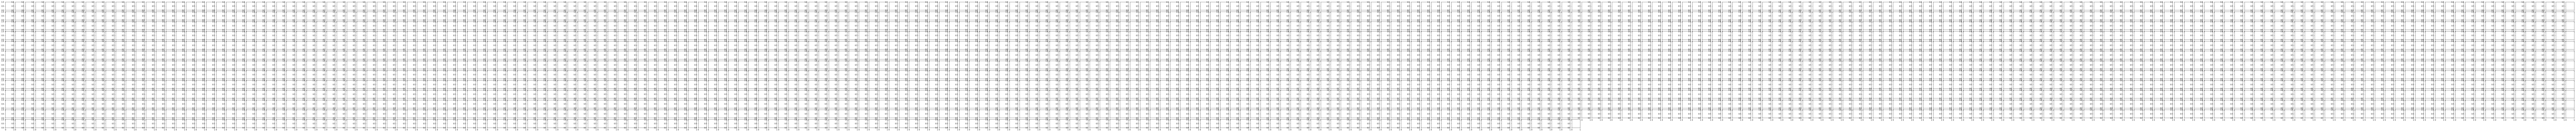

In [14]:
visualize_kernels('conv1', checkpoint['features.3.weight'], max_in_channels=100, max_out_channels=256)

In [13]:
 weight_name_to_layer_name = {
    'features.0.weight': 'conv2d-1',
    'features.3.weight': 'conv2d-4',
    'features.6.weight': 'conv2d-7',
    'features.8.weight': 'conv2d-9',
    'features.10.weight': 'conv2d-11'
  }

In [15]:
for weight_name, kernel_name in weight_name_to_layer_name.items():
    print(checkpoint[weight_name])

tensor([[[[-3.1738e-02, -2.2894e-02, -4.4810e-02,  ...,  7.6654e-03,
            2.4028e-02,  2.2772e-02],
          [-4.0397e-02,  1.2827e-02,  1.1560e-02,  ...,  2.5214e-02,
            9.3229e-04,  5.7669e-03],
          [ 4.2212e-02,  4.2109e-02, -2.9269e-03,  ...,  1.8639e-02,
            4.0549e-02, -3.7573e-02],
          ...,
          [ 1.3943e-03, -4.1469e-02,  1.1917e-02,  ...,  1.3612e-02,
            9.1871e-03, -4.6054e-02],
          [ 2.1872e-02,  4.2851e-02, -1.9223e-02,  ..., -5.1162e-02,
            2.7845e-03, -1.7759e-02],
          [ 4.0067e-02,  2.4323e-02, -2.6658e-02,  ..., -4.2400e-02,
           -4.1733e-02, -3.4517e-02]],

         [[ 9.9069e-03, -1.1624e-02, -7.0599e-03,  ..., -3.1271e-02,
            3.3239e-02,  1.0212e-02],
          [ 2.3764e-02,  3.3148e-02, -9.0834e-03,  ...,  1.8349e-02,
            5.6948e-03,  1.7874e-02],
          [ 3.2087e-02,  2.2821e-02, -4.7720e-04,  ..., -2.4897e-02,
           -4.5613e-02,  2.8311e-02],
          ...,
     